slice with tumor (240,240,1) ->
WSO: one filter, one window setting -> windowed image (240,240,1)
 ->
self-customized cnn to do clf. 

linear window function and sigmoid window function



In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import copy
import h5py
import os
import matplotlib.pyplot as plt
import math
import random

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import sklearn
import tensorflow as tf
keras = tf.keras
K = keras.backend
#from keras.optimizers import SGD, Adam
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
#from keras.models import Model, model_from_json
#from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split


**Hyperparameter**

In [ ]:
BATCH_SIZE = 32
EARLY_STOP = 10
EPOCHS = 200
RANDOM_STATE = 42

UPBOUND_VALUE = 255.0
WINDOW_FUNCTION = "relu"   # 'relu' or 'sigmoid'
RESCALE = "patient max"   # "none", "global max", "patient max", "by slice"

# Initiative window setting with default window parameters for brain image
WW = 165
WL = 82.5

# **DEFINE FUNCTIONS**

**Funtions for load and rescale data**

In [ ]:
def load_data(data_path="/content/drive/MyDrive/Master's Project/data/tumor_slices_data.h5", start=0,end=11000):
  """
  load data from h5 file, then shuffle data.
  """
  # load data from h5 file
  h5f = h5py.File(data_path,'r')

  # get data
  tm_slices = np.array(h5f['tumor_slices'])[start:end]
  Y = np.array(h5f['labels'])[start:end]
  max_hus = np.array(h5f['max_HU'][start:end])

  # shuffle data
  tm_slices, Y, max_hus = sklearn.utils.shuffle(tm_slices, Y, max_hus, random_state=RANDOM_STATE)

  
  return tm_slices, Y, max_hus


def max_min_pixel(X):
  max_val = 0
  min_val = 0
  for i, img in enumerate(X):
    max_val = max(max_val,  np.max(img))
    min_val = min(min_val, np.min(img))
  return max_val, min_val
  # max_val = 2291, min_val = 0


def rescale_data(X):
    """
        normalize data.
    """
    X = X.astype(np.float32)
    X_rescale = [0]*len(X)
    for i, img in enumerate(X):
      min_val = 0
      max_val = 2291
      img = 255.0*(img-min_val)/(max_val-min_val+1e-10)
      img = img.astype(np.float32)
      X_rescale[i] = img

    return np.array(X_rescale)


def rescale_data_for_pat(X, max_hus):
    X = X.astype(np.float32)
    X_rescale = [0]*len(X)
    for i, img in enumerate(X):
      min_val = 0
      max_val = max_hus[i]
      img = 255.0*(img-min_val)/(max_val-min_val+1e-10)
      img = img.astype(np.float32)
      X_rescale[i] = img

    return np.array(X_rescale)



def rescale_data_by_slice(X):

    X = X.astype(np.float32)
    X_rescale = [0]*len(X)
    for i, img in enumerate(X):
      min_val = 0
      max_val = np.max(img)
      img = 255.0*(img-min_val)/(max_val-min_val+1e-10)
      img = img.astype(np.float32)
      X_rescale[i] = img

    return np.array(X_rescale)



class DataSequence(tf.keras.utils.Sequence):

      def __init__(self, X, Y):
          self.X = X
          self.Y = Y

      def __len__(self):
          return math.ceil(len(self.X) / BATCH_SIZE)

      def __getitem__(self, idx):
          return [self.X[idx*BATCH_SIZE:(idx + 1)*BATCH_SIZE], self.Y[idx*BATCH_SIZE:(idx + 1)*BATCH_SIZE]]



**Define WSO**

In [ ]:
# define convolutional layer for wso
def WinOptConv(nch_window=1, **kwargs):
    conv_layer = keras.layers.Conv2D(filters=nch_window, kernel_size=(1, 1), strides=(1, 1), padding="valid",
                        name="window_conv_layer",**kwargs)
    return conv_layer

# define activation for wso
def WinOptActivation(upbound_window=UPBOUND_VALUE, window_function=WINDOW_FUNCTION):

    def upbound_sigmoid(x):
       return upbound_window * K.sigmoid(x)

    def upbound_relu(x):
        return K.minimum(K.maximum(x, 0), upbound_window)

    if window_function == "relu":
        act_layer = keras.layers.Activation(upbound_relu, name="window_act_layer")
    if window_function == "sigmoid":
        act_layer = keras.layers.Activation(upbound_sigmoid, name="window_act_layer")
    
    return act_layer


# wso with one convolutional layer and activation function
def WindowOptimizer(upbound_window=UPBOUND_VALUE, window_function=WINDOW_FUNCTION, nch_window=1, **kwargs):

    conv_layer = WinOptConv(nch_window=nch_window, **kwargs)
    act_layer = WinOptActivation(upbound_window=upbound_window, window_function= window_function)

    ## Return layer funcion
    def window_func(x):
        x = conv_layer(x)
        x = act_layer(x)
        return x

    return window_func



**Convert window parameters to weights of WSO, initialize WSO weights**

In [ ]:
# change window parameters to conv params
def get_init_conv_params_relu(wl, ww, upbound_value=UPBOUND_VALUE):
    w = upbound_value / ww
    b = -1. * upbound_value * (wl - ww / 2.) / ww
    return (w, b)

def get_init_conv_params_sigmoid(wl, ww, smooth=None, upbound_value=UPBOUND_VALUE):
    if smooth is None:
        smooth = upbound_value / 255.0

    w = 2./ww * np.log(upbound_value/smooth - 1.)
    b = -2.*wl/ww * np.log(upbound_value/smooth - 1.)
    return (w, b)


# initialize conv parameters with the WW and WL  
def initialize_window_setting(model, wl=WL, ww=WW, upbound_window=UPBOUND_VALUE, window_function=WINDOW_FUNCTION):

    if window_function == "relu":
        w_new, b_new = get_init_conv_params_relu(wl, ww, upbound_window)
    if window_function == "sigmoid":
        w_new, b_new = get_init_conv_params_sigmoid(wl, ww)
    
    layer_names = [layer.name for layer in model.layers]

    w_conv_ori, b_conv_ori = model.layers[layer_names.index("window_conv_layer")].get_weights()
    w_conv_new = np.zeros_like(w_conv_ori)
    w_conv_new[0,0,0,:] = w_new * np.ones(w_conv_ori.shape[-1], dtype=w_conv_ori.dtype)
    b_conv_new = b_new * np.ones(b_conv_ori.shape, dtype=b_conv_ori.dtype)

    model.layers[layer_names.index("window_conv_layer")].set_weights([w_conv_new, b_conv_new])

    return model

**Compile Model (WSO + pre-trained CNN)**

In [ ]:
# compile model 
input_shape = (240,240,1)
input_tensor = keras.layers.Input(shape=input_shape, name="input")

# wso, output of this layer is windowed image
x = WindowOptimizer(nch_window=1, upbound_window=UPBOUND_VALUE,
                    window_function=WINDOW_FUNCTION,
                    kernel_initializer="he_normal",
                    kernel_regularizer=keras.regularizers.l2(0.5 * 1e-5)
                    )(input_tensor)

# self-customized CNN
cnn = keras.Sequential()

cnn.add(keras.layers.Conv2D(64, (2, 2), input_shape=(240,240,1)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.Conv2D(64, (2, 2)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(keras.layers.Conv2D(128,(2, 2)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.Conv2D(128, (2, 2)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(keras.layers.Conv2D(64,(2, 2)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.Conv2D(64, (2, 2)))
cnn.add(keras.layers.BatchNormalization(axis=-1))
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(keras.layers.Flatten())
# Fully connected layer
cnn.add(keras.layers.Dense(512))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.Activation('relu'))
cnn.add(keras.layers.Dropout(0.2))
cnn.add(keras.layers.Dense(3))
cnn.add(keras.layers.Activation('softmax'))

outputs = cnn(x)
model = keras.models.Model(inputs=input_tensor, outputs=outputs, name="main_model")
    
## Initialize parameters of window setting opt module
model = initialize_window_setting(model)

optimizer = keras.optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=["accuracy"])
model.summary()

Model: "main_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 240, 240, 1)]     0         
_________________________________________________________________
window_conv_layer (Conv2D)   (None, 240, 240, 1)       2         
_________________________________________________________________
window_act_layer (Activation (None, 240, 240, 1)       0         
_________________________________________________________________
sequential (Sequential)      (None, 3)                 25860867  
Total params: 25,860,869
Trainable params: 25,858,821
Non-trainable params: 2,048
_________________________________________________________________


In [ ]:
#intermediate_layer_model_initiative = keras.Model(inputs=model.input, outputs=model.get_layer ("window_act_layer").output)

**Get weights and convert weights to window parameters**

In [ ]:
## get the weights of the WSO convolutional layer
def get_weights(model, layer_name="window_conv_layer"):
  names = [weight.name for layer in model.layers for weight in layer.weights]
  #print(names)
  weights = model.get_weights()

  for name, weight in zip(names, weights):
    if "window_conv_layer" in name:
      if "kernel:0" in name:
        ws = weight
      if "bias:0" in name:
        bs = weight

  #print("w={} b={}".format(ws[0, 0, 0, :], bs))
  #print(ws)
  #print(ws.shape)
  w = ws[0,0,0,:]
  b = bs
  print("w={},b={}".format(w,b))
  return w, b


In [ ]:
# convert weights w,b to window parameters wl, ww
def convert_weights_to_window_params(w,b,upbound_value=UPBOUND_VALUE, window_function=WINDOW_FUNCTION):
  if window_function == "relu":
    return convert_weights_to_window_params_relu(w, b,upbound_value=upbound_value)
  if window_function == "sigmoid":
    return convert_weights_to_window_params_sigmoid(w, b, smooth=None, upbound_value=upbound_value)


def convert_weights_to_window_params_sigmoid(w, b, smooth=None, upbound_value=UPBOUND_VALUE):
    if smooth is None:
        smooth = upbound_value / 255.0

    wl = -1.* b / w
    ww = 2./w * np.log(upbound_value/smooth - 1.)
    print("corresponding windowing setting for the windowed image: WL={}, WW={}".format(wl, ww))
    return wl, ww


def convert_weights_to_window_params_relu(w,b, upbound_value=UPBOUND_VALUE):
  wl = upbound_value/(2.*w) - b/w     
  ww = upbound_value / w
  print("corresponding windowing setting for the windowed image: WL={}, WW={}".format(wl, ww))
  return wl, ww


**Get value distribution of slice**

In [ ]:
def get_distribution(x):
  pixel_values = list(filter(lambda e: e!= 0, x[0,:,:,0].flatten()))
  plt.hist(pixel_values)
  plt.show

# **TRAIN MODEL**

Get data

In [ ]:
tm_slices, Y, max_hus = load_data()

def split(tm_slices, rescale=RESCALE):
  if rescale == "global max":
    ### rescale with global max HU###
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(rescale_data(tm_slices), Y, test_size=0.1, random_state=RANDOM_STATE)
  elif rescale == "none":
    ### no rescale ###
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(tm_slices, Y, test_size=0.1, random_state=RANDOM_STATE)
  elif rescale == "patient max":  
    ### rescale according to patients###
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(rescale_data_for_pat(tm_slices, max_hus), Y, test_size=0.1, random_state=RANDOM_STATE)
  elif rescale == "by slice":
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(rescale_data_by_slice(tm_slices), Y, test_size=0.1, random_state=RANDOM_STATE)

  return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = split(tm_slices)

# check the weights before training
init_w, init_b = get_weights(model)

w=[1.5454545],b=[-0.]


Fit model

In [ ]:
# fit model
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=EARLY_STOP, restore_best_weights=True)
history = model.fit(X_train,Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, callbacks=[es])

Epoch 1/200
248/248 [==============================] - 128s 372ms/step - loss: 0.9084 - accuracy: 0.5988 - val_loss: 0.6515 - val_accuracy: 0.7157
Epoch 2/200
248/248 [==============================] - 91s 367ms/step - loss: 0.2217 - accuracy: 0.9354 - val_loss: 0.1931 - val_accuracy: 0.9485
Epoch 3/200
248/248 [==============================] - 92s 371ms/step - loss: 0.0815 - accuracy: 0.9853 - val_loss: 0.0850 - val_accuracy: 0.9823
Epoch 4/200
248/248 [==============================] - 92s 373ms/step - loss: 0.0531 - accuracy: 0.9883 - val_loss: 0.0667 - val_accuracy: 0.9833
Epoch 5/200
248/248 [==============================] - 92s 373ms/step - loss: 0.0269 - accuracy: 0.9965 - val_loss: 0.0675 - val_accuracy: 0.9859
Epoch 6/200
248/248 [==============================] - 93s 373ms/step - loss: 0.0155 - accuracy: 0.9986 - val_loss: 0.0217 - val_accuracy: 0.9965
Epoch 7/200
248/248 [==============================] - 93s 373ms/step - loss: 0.0123 - accuracy: 0.9981 - val_loss: 0.0358 

visualize accuracy and loss

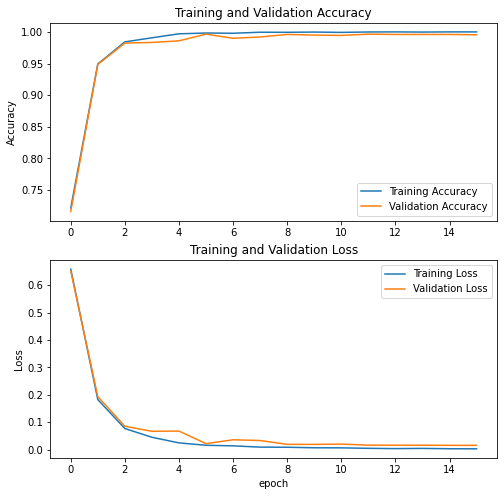

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

evaluate model

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss = {}, Test accuracy = {}".format(loss, accuracy))

35/35 - 4s - loss: 0.0262 - accuracy: 0.9945
Test loss = 0.026210982352495193, Test accuracy = 0.9945454597473145


In [ ]:
w, b = get_weights(model)
wl,ww = convert_weights_to_window_params(w,b)
print("w = ", w)
print("b = ", b)

w=[1.5891172],b=[-0.00066247]
corresponding windowing setting for the windowed image: WL=[80.23365], WW=[160.46646]
w =  [1.5891172]
b =  [-0.00066247]


In [ ]:
# save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
!cp model.h5 "/content/drive/MyDrive/Master's Project/model/customcnn11000"

In [ ]:
!cp model.json "/content/drive/MyDrive/Master's Project/model/customcnn11000"